<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/drakenew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/data_vit/split_dataset/train'
test_dir = '/content/drive/MyDrive/data_vit/split_dataset/test'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import accuracy_score

# Configuration and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
learning_rate = 0.0001

# Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model Setup
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

# Save the trained model
torch.save(model.state_dict(), 'vit_model.pth')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm

# Configuration and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
additional_epochs = 4
learning_rate = 0.0001

# Data Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load and setup model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('vit_model.pth'))
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize best validation accuracy
best_val_accuracy = 0

# Continue Training Loop
for epoch in range(additional_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy}%")

    # Checkpoint model if improved
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print("Saved improved model")

print('Finished additional training!')

In [ ]:
pip install torch torchvision timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/tomato/tomato/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/content/tomato/tomato/valid', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the best model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)
model.eval()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluate on training data
train_loss, train_correct, train_total = 0, 0, 0
train_preds, train_targets = [], []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_targets, train_preds)
train_precision = precision_score(train_targets, train_preds, average='weighted')
train_recall = recall_score(train_targets, train_preds, average='weighted')
train_f1 = f1_score(train_targets, train_preds, average='weighted')

# Evaluate on validation data
val_correct, val_total = 0, 0
val_preds, val_targets = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_preds)
val_precision = precision_score(val_targets, val_preds, average='weighted')
val_recall = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

# Print metrics
print(f'Train Loss: {train_loss / len(train_loader):.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.0662
Train Accuracy: 0.9791
Validation Accuracy: 0.9850
Train Precision: 0.9798
Train Recall: 0.9791
Train F1 Score: 0.9791
Validation Precision: 0.9862
Validation Recall: 0.9850
Validation F1 Score: 0.9852


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
import os
os.chdir(f'./Transformer-Explainability')

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 29.20 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import timm
from PIL import Image
from collections import OrderedDict
from modules.layers_ours import *
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

CLS2IDX = {0: 'agricultural',
           1: 'airplane',
           2: 'baseballdiamond',
           3: 'beach',
           4: 'buildings',
           5: 'chaparral',
           6: 'denseresidential',
           7: 'forest',
           8: 'freeway',
           9: 'golfcourse',
           10: 'harbor',
           11: 'intersection',
           12: 'mediumresidential',
           13: 'mobilehomepark',
           14: 'overpass',
           15: 'parkinglot',
           16: 'river',
           17: 'runway',
           18: 'sparseresidential',
           19: 'storagetanks',
           20: 'tenniscourt'}

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

In [ ]:
mean = [0.485, 0.456, 0.406] # our images have three channels
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])
resizing =  transforms.Resize((224,224))



In [ ]:
num_classes = 10
model =  vit_LRP(pretrained=True)
num_ftrs = model.head.in_features
model.head = Linear(num_ftrs, num_classes)
# load state dictionary
state_dict = torch.load('/content/best_vit_model.pth')
print("[Loading Weights to the Model]")
model.load_state_dict(state_dict)
model.cuda() # put model on GPU
model.eval()
attribution_generator = LRP(model)

[Loading Weights to the Model]


In [ ]:
import torch
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# Initialize the model
model = vit_LRP(pretrained=False, num_classes=10)  # Ensure num_classes matches your dataset
model = model.cuda()

# Load the saved state dictionary
state_dict = torch.load('/content/best_vit_model.pth')
model.load_state_dict(state_dict)

model.eval()  # Set the model to evaluation mode
attribution_generator = LRP(model)


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	9 : Tomato___healthy           		value = -3.504	 prob = 71.2%
	6 : Tomato___Target_Spot       		value = -5.257	 prob = 12.3%
	5 : Tomato___Septoria_leaf_spot		value = -5.668	 prob = 8.2%
	3 : Tomato___Leaf_Mold         		value = -6.360	 prob = 4.1%
	4 : Tomato___Septoria_leaf_spot		value = -7.220	 prob = 1.7%


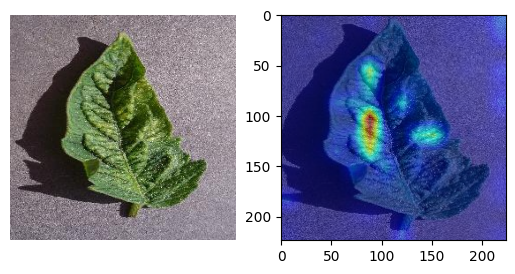

In [ ]:
image = Image.open('/content/tomato/tomato/valid/Tomato___Spider_mites Two-spotted_spider_mite/0a246e71-0551-4603-a017-d1dfc4ea06be___Com.G_SpM_FL 1178.JPG')
tomato_image = transform(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tomato_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
Tomato___Bacterial_spot = generate_visualization(tomato_image)

tomato = generate_visualization(image, class_index=5)

axs[1].imshow(Tomato___Bacterial_spot );
#axs[1].axis('off');
